# Understanding on-policy and off-policy properties 

In this part, we investigate the difference between the off-policy property of Q-learning and the on-policy property of SARSA. For doing so, we will feed the critic of these algorithms with off-policy data stored into a replay buffer.
Using a replay buffer is not mandatory when using random uniform samples, but using this approach makes the architecture more flexible for later experiments.

### Create a class Sample

A sample contains the following information : the current state, the current action, the resulting reward, and the resulting next state.

In the cell below, create a class to store a sample

In [1]:
"define your Sample class here"
class Sample:
    
    def __init__(self, x, u, r, y, done):
        self.x = x
        self.u = u
        self.r = r
        self.y = y
        self.done = done
    
    def unwrap(self):
        return self.x, self.u, self.r, self.y
    
    def __str__(self):
        return "{} {} {} {} {}".format(self.x, self.u, self.r, self.y, self.done)
    
    def __repr__(self):
        return "{} {} {} {} {}".format(self.x, self.u, self.r, self.y, self.done)

### Create a class ReplayBuffer

A replay buffer is a FIFO list of samples with a limited size (often set to 10^6). 

In the cell below, create a class ReplayBuffer. Give it a method __add(sample)__ to add a sample, a method __draw()__ to draw a sample randomly

In [2]:
"define your ReplayBuffer class here"
import collections

class ReplayBuffer:
    
    def __init__(self, buffer_size=10e6):
        self.buffer_size = buffer_size
        self.buffer = collections.deque(maxlen=self.buffer_size)
        
    def push(self, sample, overwrite=True):

        """ If maximum buffer size reached , remove old experience """
        if len(self.buffer) == self.buffer_size:
            self.buffer.popleft()

        """ Add new experience """
        self.buffer.append(sample)
        
    def draw(self):
        indices = np.random.randint(0, len(self.buffer))
        return self.buffer[indices]
    
    def __len__(self):
        return len(self.buffer)

In your mdp class, add a method __uniformSampling()__ which returns a randomly generated sample: it draws a state and an action at random, provides the corresponding reward and next state, stores these into a sample and returns that sample.

In the box below, get your Q-learning code from [reinforcement_learning.ipynb](reinforcement_learning.ipynb), and copy-paste it.

In [22]:
"copy-paste your Q-learning code here"
import numpy as np
from ipynb.fs.defs.toolbox import softmax

########################### Q-Learning ###########################
    
# Given a temperature "tau", the QLearning function computes the state action-value function 
# based on a softmax policy 
def QLearning(mdp, tau, rb, nEpisodes=5000,  nTimesteps=500, alpha=0.01, render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
    
    if render:
        mdp.new_render()
        
    for i in range(nEpisodes) :
        
        timesteps = 0
        
        done = False
        
        while not done:
            
            if render :
                # Show the agent in the maze
                mdp.render(Q, Q.argmax(axis=1))
        
            sample = rb.draw()
        
            x = sample.x
            u = sample.u
            r = sample.r
            y = sample.y
            
            done = sample.done
            
            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r
                
            else:
                delta = r + mdp.gamma * Q[y, np.argmax(Q[y])] - Q[x, u]
                Q[x,u] = Q[x,u] + alpha * delta
            
            timesteps = timesteps + 1
            
            if done is False:
                done = timesteps > nTimesteps
                
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))

    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
        
    return [Q_list, policy_list]

Modify the above code so that, instead of being fed by the samples of an agent running its current policy, the Q-table is fed by samples drawn randomly from the replay buffer.


### Writing the main code
 
 Below, write a code that:
 * creates a replay buffer containing 10.000 samples drawn uniformly from the mdp,
 * makes Q-learning learn from samples drawn uniformly from the replay buffer for a fixed number of episodes,
 * visualizes the results.


In [23]:
"run modified Qlearning"

import ipynb.fs.defs.my_mdp as my_mdp
from ipynb.fs.defs.maze_plotter import maze_plotter # used for visualization of the state value and policy evolution

walls = [6, 13, 14, 15]
height = 4
width = 5
terminal_states=[width*height-1]
m = my_mdp.maze_mdp(width, height, walls=walls, terminal_states=terminal_states)

tau = 0.01

rb = ReplayBuffer(buffer_size=10000)

for i in range(10000):
    sample = m.uniformSampling()
    rb.push(sample)

Q_list, policy_list = QLearning(m, tau, rb, render=False)

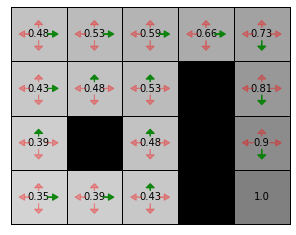

In [24]:
"visualize your results here, it is better to do it in a different cell than the one that runs your algorithm so"
"you can customize your rendering to your heart's content !"

from IPython.display import HTML  # used to display the video on the notebook

m.new_render()
m.render(Q_list[-1], policy_list[-1])  # QPI_list is the list of the Q values processed at each episode, 

What do you observe? Is this algorithm converging to an optimal Q-table?

Yes it does. Since the only different thing is how the samples are drawn but they are coming from the same MDP

Now, do the same with SARSA: import it below, and modify it as you did for Q-learning (or just change your modified Q-learning into a modified SARSA below, this is easier).


In [9]:
"write your SARSA code here"
"write SARSA here"

"copy-paste and replace here"
import numpy as np
from ipynb.fs.defs.toolbox import softmax
from ipynb.fs.defs.toolbox import discreteProb

########################### Q-Learning ###########################
    
# Given a temperature "tau", the QLearning function computes the state action-value function 
# based on a softmax policy 
def Sarsa(mdp, tau, rb, nEpisodes=10000,nTimesteps=50,alpha=0.01,render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
    
    if render:
        mdp.new_render()
        
    for i in range(nEpisodes) :
         
        timesteps = 0
        done = False
        
        while not done:
            
            sample = rb.draw()
        
            x = sample.x
            u = sample.u
            r = sample.r
            y = sample.y
            
            done = sample.done
            
            if render :
                # Show the agent in the maze
                mdp.render(Q, Q.argmax(axis=1))
            
            # Draw an action (t + 1) using an epsilon greedy policy
            if np.random.rand(1) < 0.1:
                ut = mdp.action_space.sample()  
            else:
                if y == 20:
                    ut = 0
                else:
                    ut = np.argmax(Q[y])

            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r
            else:
                Q[x, u] = Q[x, u] + alpha * (r + mdp.gamma * Q[y, ut] - Q[x, u])
            
            if done is False:
                done = timesteps > nTimesteps
            
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))

    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
        
    return [Q_list, policy_list]

In [10]:
"run your modified SARSA code here"
"run modified Qlearning"

import import_ipynb
import my_mdp
from ipynb.fs.defs.maze_plotter import maze_plotter # used for visualization of the state value and policy evolution

walls = [6, 13, 14, 15]
height = 4
width = 5
terminal_states=[width*height-1]
m = my_mdp.maze_mdp(width, height, walls=walls, terminal_states=terminal_states)

tau = 0.01

rb = ReplayBuffer(buffer_size=10000)

for i in range(10000):
    sample = m.uniformSampling()
    rb.push(sample)

Q_list, policy_list = Sarsa(m, tau, rb, render=False)

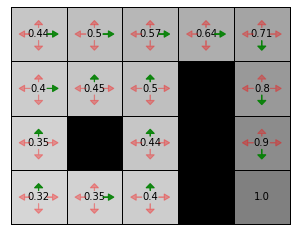

In [11]:
"visualize your results here"
"visualize your results here, it is better to do it in a different cell than the one that runs your algorithm so"
"you can customize your rendering to your heart's content !"

from IPython.display import HTML  # used to display the video on the notebook

m.new_render()
m.render(Q_list[-1], policy_list[-1])  # QPI_list is the list of the Q values processed at each episode, 

Again, what do you observe? Is this algorithm converging to an optimal Q-table?
Discuss the difference.
To go further and better understand the convergence properties of SARSA, read [the paper where its convergence was proven](https://link.springer.com/content/pdf/10.1023/A:1007678930559.pdf)

While slightly different on the ties, the Q-table is optimal and therefore the resulting policy is also optimal